# Var model for GDP prediction

In [1]:
import pickle
import warnings
from math import sqrt
import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import tensorflow as tf
from sklearn import model_selection
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from sklearn import linear_model, svm
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import tqdm_notebook
from itertools import product
# Import Statsmodels
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False
# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['figure.figsize'] = 18, 8


In [2]:
#importing the dataset
#importing the dataset
#from google.colab import drive
#drive.mount('/content/Mydrive')
#df2= pd.read_csv('Mydrive/My Drive/full_GDP_data.csv')
df2= pd.read_csv('da.csv')
df2

,years,GDP,EXP__INF,GDP_TELE,N_INTE_USERS,N_MOBILE__SUBS,POPULATION
0,2002Q1,93.4,485.0,542.0,150.0,449.0,4246.0
1,2002Q2,87.4,527.0,554.0,168.0,482.0,4278.0
2,2002Q3,87.2,568.0,566.0,185.0,515.0,4310.0
3,2002Q4,86.5,609.0,577.0,202.0,547.0,4343.0
4,2003Q1,96.4,651.0,589.0,220.0,580.0,4375.0
...,...,...,...,...,...,...,...
68,2019Q1,975.2,1646.0,1836.0,3530.0,9534.0,6113.0
69,2019Q2,1007.4,1726.0,1904.0,2758.0,9534.0,6139.0
70,2019Q3,976.1,1807.0,1973.0,1985.0,9535.0,6165.0
71,2019Q4,1004.7,1888.0,2042.0,1212.0,9535.0,6191.0


In [3]:
#f2.drop(columns=['POPULATION'], inplace=True)

In [4]:
df2.head()

,years,GDP,EXP__INF,GDP_TELE,N_INTE_USERS,N_MOBILE__SUBS,POPULATION
0,2002Q1,93.4,485.0,542.0,150.0,449.0,4246.0
1,2002Q2,87.4,527.0,554.0,168.0,482.0,4278.0
2,2002Q3,87.2,568.0,566.0,185.0,515.0,4310.0
3,2002Q4,86.5,609.0,577.0,202.0,547.0,4343.0
4,2003Q1,96.4,651.0,589.0,220.0,580.0,4375.0


In [5]:
df=df2.copy()

In [6]:
column_to_move = df.pop("GDP")

#insert column with insert(location, column_name, column_value)

df.insert(1, "GDP", column_to_move)

In [7]:
#convert data to datatime index
df['datetime'] = pd.to_datetime(df['years'])
df = df.set_index('datetime')
df.drop(['years'], axis=1, inplace=True)
#df = df.sort_index(ascending=True)
df.head()

,GDP,EXP__INF,GDP_TELE,N_INTE_USERS,N_MOBILE__SUBS,POPULATION
datetime,,,,,,
2002-01-01,93.4,485.0,542.0,150.0,449.0,4246.0
2002-04-01,87.4,527.0,554.0,168.0,482.0,4278.0
2002-07-01,87.2,568.0,566.0,185.0,515.0,4310.0
2002-10-01,86.5,609.0,577.0,202.0,547.0,4343.0
2003-01-01,96.4,651.0,589.0,220.0,580.0,4375.0


In [8]:
#convert data to datatime index
#df['date'] = pd.to_datetime(df['years'])
#df = df.set_index('date')
#df.drop(['years'], axis=1, inplace=True)
#df = df.sort_index(ascending=True)
#df.head()
#df['years']=pd.Series(df['years'])
#convert data to datatime index

#df = df.set_index('years')
#df = df.sort_index(ascending=True)df.head()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73 entries, 2002-01-01 to 2020-01-01
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GDP             73 non-null     float64
 1   EXP__INF        73 non-null     float64
 2   GDP_TELE        73 non-null     float64
 3   N_INTE_USERS    73 non-null     float64
 4   N_MOBILE__SUBS  73 non-null     float64
 5   POPULATION      73 non-null     float64
dtypes: float64(6)
memory usage: 4.0 KB


In [10]:
#g=['years','GDP']
#df1=df.columns.difference(g)
#df[df1]=df[df1].div(10000).round()

In [11]:
df

,GDP,EXP__INF,GDP_TELE,N_INTE_USERS,N_MOBILE__SUBS,POPULATION
datetime,,,,,,
2002-01-01,93.4,485.0,542.0,150.0,449.0,4246.0
2002-04-01,87.4,527.0,554.0,168.0,482.0,4278.0
2002-07-01,87.2,568.0,566.0,185.0,515.0,4310.0
2002-10-01,86.5,609.0,577.0,202.0,547.0,4343.0
2003-01-01,96.4,651.0,589.0,220.0,580.0,4375.0
...,...,...,...,...,...,...
2019-01-01,975.2,1646.0,1836.0,3530.0,9534.0,6113.0
2019-04-01,1007.4,1726.0,1904.0,2758.0,9534.0,6139.0
2019-07-01,976.1,1807.0,1973.0,1985.0,9535.0,6165.0


In [12]:
#df.to_csv('da.csv',index=False)

In [13]:
#df=df.iloc[:,df.columns!='GDP'].div(10000).round()
#df

In [14]:
df.head()

,GDP,EXP__INF,GDP_TELE,N_INTE_USERS,N_MOBILE__SUBS,POPULATION
datetime,,,,,,
2002-01-01,93.4,485.0,542.0,150.0,449.0,4246.0
2002-04-01,87.4,527.0,554.0,168.0,482.0,4278.0
2002-07-01,87.2,568.0,566.0,185.0,515.0,4310.0
2002-10-01,86.5,609.0,577.0,202.0,547.0,4343.0
2003-01-01,96.4,651.0,589.0,220.0,580.0,4375.0


In [15]:
x=df.drop(['GDP'],axis=1)
y=df['GDP']

In [16]:
from sklearn.linear_model import LinearRegression

#initiate linear regression model
model = LinearRegression()



#fit regression model
model.fit(x, y)

#calculate R-squared of regression model
r_squared = model.score(x, y)

#view R-squared value
print(r_squared)

0.9835576246621728


In [17]:
df=df.astype('float')

#VAR Model

### 1- Visualize the Time Series

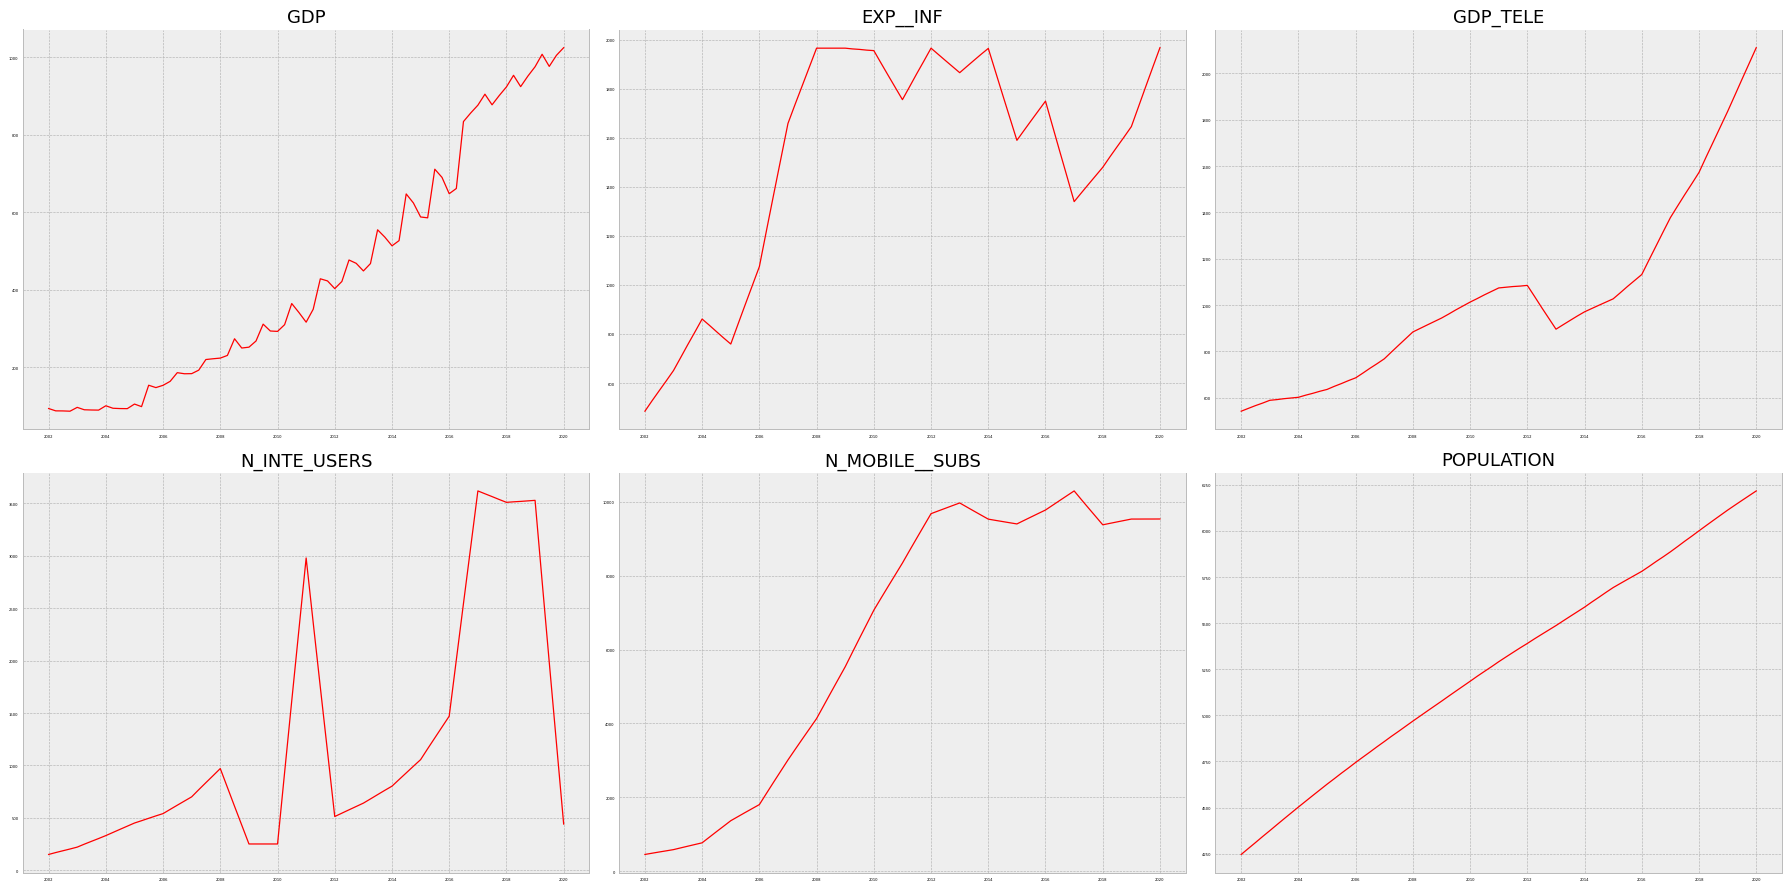

In [18]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=3, dpi=90, figsize=(20,10))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=3)

plt.tight_layout();

### 2-  Testing Causation using Granger’s Causality Test

In [19]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=2
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)    

C:\Users\20111\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\20111\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\20111\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\20111\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\20111\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\20111\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions shou

,GDP_x,EXP__INF_x,GDP_TELE_x,N_INTE_USERS_x,N_MOBILE__SUBS_x,POPULATION_x
GDP_y,1.0000,0.3111,0.5549,0.4543,0.1116,0.0025
EXP__INF_y,0.6619,1.0000,0.2989,0.1854,0.0196,0.4438
GDP_TELE_y,0.0976,0.0002,1.0000,0.0076,0.0001,0.1623
N_INTE_USERS_y,0.0704,0.7174,0.0017,1.0000,0.1664,0.1198
N_MOBILE__SUBS_y,0.0000,0.0000,0.3288,0.0661,1.0000,0.0190
POPULATION_y,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


In [20]:
#df.drop(columns=['EXP__INF'], inplace=True)
#df.drop(columns=['Exp_vehicles','Exp_food','Imp_metel','Exp_metel','Net_Foreign','Exp_chemical','Exp_oil','Imp_food','Imp_vehicles',"Imp_chemical"], inplace=True)
#df[0:4]


### 3- Cointegration Test اختبار التكامل المشترك

In [21]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,3), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
GDP    ::  157.036   > 83.9383   =>   True
EXP__INF ::  103.521   > 60.0627   =>   True
GDP_TELE ::  64.951    > 40.1749   =>   True
N_INTE_USERS ::  38.815    > 24.2761   =>   True
N_MOBILE__SUBS ::  17.296    > 12.3212   =>   True
POPULATION ::  0.835     > 4.1296    =>   False


###### 5- Check for Stationarity and Make the Time Series Stationary 

In [22]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [23]:
adf_test(df['GDP'])

Augmented Dickey-Fuller Test: 
ADF test statistic       1.243711
p-value                  0.996274
# lags used              4.000000
# observations          68.000000
critical value (1%)     -3.530399
critical value (5%)     -2.905087
critical value (10%)    -2.590001
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [24]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [25]:
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "GDP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.2437
 No. Lags Chosen       = 4
 Critical value 1%     = -3.53
 Critical value 5%     = -2.905
 Critical value 10%    = -2.59
 => P-Value = 0.9963. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "EXP__INF" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.0522
 No. Lags Chosen       = 5
 Critical value 1%     = -3.532
 Critical value 5%     = -2.906
 Critical value 10%    = -2.59
 => P-Value = 0.2641. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "GDP_TELE" 
    -----------------------------------------------
 Null Hypothesis: Data has unit

C:\Users\20111\AppData\Local\Temp\ipykernel_16660\1973961402.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in df.iteritems():


In [26]:
# 1st difference
df_differenced = df.diff().dropna()

In [27]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "GDP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.3218
 No. Lags Chosen       = 3
 Critical value 1%     = -3.53
 Critical value 5%     = -2.905
 Critical value 10%    = -2.59
 => P-Value = 0.0139. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "EXP__INF" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8119
 No. Lags Chosen       = 4
 Critical value 1%     = -3.532
 Critical value 5%     = -2.906
 Critical value 10%    = -2.59
 => P-Value = 0.3746. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "GDP_TELE" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary

C:\Users\20111\AppData\Local\Temp\ipykernel_16660\1957205119.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in df_differenced.iteritems():


In [28]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(d):
  for col in d.columns:
    dtest= adfuller(d[col])
    doutput=pd.Series(dtest[0:4],index=['the test statistic','Mackinno s approximate p-value', '#usedlags','NOBS' ])
    print('columns name:',col)
    print(doutput)   
df1=df_differenced.diff().dropna()
test_stationarity(df1.diff().dropna()) #1 diff

columns name: GDP
the test statistic                -5.634832
Mackinno s approximate p-value     0.000001
#usedlags                          9.000000
NOBS                              60.000000
dtype: float64
columns name: EXP__INF
the test statistic                -3.079047
Mackinno s approximate p-value     0.028143
#usedlags                         11.000000
NOBS                              58.000000
dtype: float64
columns name: GDP_TELE
the test statistic                -5.082239
Mackinno s approximate p-value     0.000015
#usedlags                         10.000000
NOBS                              59.000000
dtype: float64
columns name: N_INTE_USERS
the test statistic                -5.113653
Mackinno s approximate p-value     0.000013
#usedlags                          8.000000
NOBS                              61.000000
dtype: float64
columns name: N_MOBILE__SUBS
the test statistic               -6.280749e+00
Mackinno s approximate p-value    3.801862e-08
#usedlags             

In [29]:
# ADF Test on each column of 3st Differences Dataframe(الفروق الثالثه)
for name, column in df1.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "GDP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -19.0191
 No. Lags Chosen       = 2
 Critical value 1%     = -3.53
 Critical value 5%     = -2.905
 Critical value 10%    = -2.59
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "EXP__INF" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.0498
 No. Lags Chosen       = 3
 Critical value 1%     = -3.532
 Critical value 5%     = -2.906
 Critical value 10%    = -2.59
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GDP_TELE" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 

C:\Users\20111\AppData\Local\Temp\ipykernel_16660\3577606352.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in df1.iteritems():


After 3st difference the dataset become stationary

### 4- Split the Series into Training and Testing Data

In [37]:
nobs = 3
train = df1[:-nobs]
test = df1[-nobs:]

In [38]:
len(train), len(test)


(68, 3)

### 5- Select and train the Order (P) of VAR model

In [39]:
p = [0,1,2,3,4,5,6,7]  # try with list of 7 p values

for i in p:
    model = VAR(train)
    results = model.fit(i)
    print(f'VAR Order {i}')
    print('AIC {}'.format(results.aic))
    print('BIC {}'.format(results.bic))
    print('FPE {}'.format(results.fpe))
    print('HQIC {}'.format(results.hqic))
    print()

VAR Order 0
AIC 39.23396805960401
BIC 39.429806974766606
FPE 1.094211706974197e+17
HQIC 39.311565435551366

VAR Order 1
AIC 40.07735325688958
BIC 41.4593993765078
FPE 2.5548627872663786e+17
HQIC 40.62423236317257

VAR Order 2
AIC 40.76647375018025
BIC 43.35424753621148
FPE 5.2269421865829843e+17
HQIC 41.789026166704424

VAR Order 3
AIC 40.4681574612752
BIC 44.281698211553696
FPE 4.176906859345105e+17
HQIC 41.97284376234261

VAR Order 4
AIC 39.07606902835844
BIC 44.13595125498267
FPE 1.2153970202749336e+17
HQIC 41.06941222513839

VAR Order 5
AIC 39.73375629310051
BIC 46.06110643768504
FPE 3.159459865221586e+17
HQIC 42.22233403212307

VAR Order 6
AIC 40.16775311019827
BIC 47.78426655342424
FPE 8.330973851734679e+17
HQIC 43.158188445915634

VAR Order 7
AIC 40.98846309106157
BIC 49.91642140182738
FPE 4.987974278843659e+18
HQIC 44.48741362324104



C:\Users\20111\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\20111\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\20111\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\20111\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\20111\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-

In [40]:
x = model.select_order(maxlags=7)
x.summary()

,AIC,BIC,FPE,HQIC
0,39.82,40.03*,1.974e+17*,39.91*
1,40.68,42.13,4.653e+17,41.24
2,41.36,44.06,9.570e+17,42.42
3,41.03,44.98,7.526e+17,42.58
4,39.54*,44.74,2.030e+17,41.58
5,40.07,46.50,4.702e+17,42.59
6,40.36,48.04,1.076e+18,43.37
7,40.99,49.92,4.988e+18,44.49


In [41]:
model.endog_names

['GDP', 'EXP__INF', 'GDP_TELE', 'N_INTE_USERS', 'N_MOBILE__SUBS', 'POPULATION']

In [42]:
results = model.fit(1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 01, Jun, 2024
Time:                     13:51:28
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    41.4594
Nobs:                     67.0000    HQIC:                   40.6242
Log likelihood:          -1871.00    FPE:                2.55486e+17
AIC:                      40.0774    Det(Omega_mle):     1.40743e+17
--------------------------------------------------------------------
Results for equation GDP
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.415601         6.532150           -0.064           0.949
L1.GDP                   -0.336451         0.117976           -2.852           0.004
L1.EXP__INF              -0.229017         0.2

In [43]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

for col, val in zip(train.columns, out):
    print((col), ':', round(val, 2))

GDP : 2.24
EXP__INF : 1.96
GDP_TELE : 2.0
N_INTE_USERS : 1.84
N_MOBILE__SUBS : 2.01
POPULATION : 1.95


In [44]:
lag_order = results.k_ar
lag_order

1

In [45]:
z = results.forecast(y=train.values[-lag_order:],steps = 3)
z

array([[-5.86791695e+00, -1.66922493e+01, -1.87817374e+00,
         1.24731352e+02, -1.39474332e+01,  7.15968346e-01],
       [ 2.55039074e+00,  5.19871753e+00,  1.52024839e+00,
        -4.87777659e+01,  2.90013543e+00, -3.02765172e-01],
       [-3.08119111e-01, -9.71738045e-01,  6.01418230e-01,
         6.71641460e-01, -1.64343925e+00, -1.76570110e-02]])

In [46]:
test


,GDP,EXP__INF,GDP_TELE,N_INTE_USERS,N_MOBILE__SUBS,POPULATION
datetime,,,,,,
2019-07-01,-63.5,1.0,1.0,-1.0,1.0,0.0
2019-10-01,59.9,0.0,0.0,0.0,-1.0,0.0
2020-01-01,-8.9,-1.0,0.0,1.0,1.0,0.0


### 6- Forecast VAR model using statsmodels

```
# This is formatted as code
```



In [47]:
idx = pd.date_range(start='2019Q3',periods=3,freq='Q')
df_forecast = pd.DataFrame(z,index=idx,columns=['GDP2D','EXP__INF2D','GDP_TELE2D','N_INTE_USERS2D','N_MOBILE__SUBS2D','POPULATION2D'])

In [48]:
df_forecast


,GDP2D,EXP__INF2D,GDP_TELE2D,N_INTE_USERS2D,N_MOBILE__SUBS2D,POPULATION2D
2019-09-30,-5.867917,-16.692249,-1.878174,124.731352,-13.947433,0.715968
2019-12-31,2.550391,5.198718,1.520248,-48.777766,2.900135,-0.302765
2020-03-31,-0.308119,-0.971738,0.601418,0.671641,-1.643439,-0.017657


In [49]:
df_forecast['GDP1D'] = (df['GDP'].iloc[-nobs-1] - df['GDP'].iloc[-nobs-2]) + df_forecast['GDP2D'].cumsum()

In [50]:
# Now build the forecast values from the first difference set
df_forecast['GDPForecast'] = df['GDP'].iloc[-nobs-1] + df_forecast['GDP2D'].cumsum()

In [51]:
df_forecast


,GDP2D,EXP__INF2D,GDP_TELE2D,N_INTE_USERS2D,N_MOBILE__SUBS2D,POPULATION2D,GDP1D,GDPForecast
2019-09-30,-5.867917,-16.692249,-1.878174,124.731352,-13.947433,0.715968,26.332083,1001.532083
2019-12-31,2.550391,5.198718,1.520248,-48.777766,2.900135,-0.302765,28.882474,1004.082474
2020-03-31,-0.308119,-0.971738,0.601418,0.671641,-1.643439,-0.017657,28.574355,1003.774355


In [52]:
# Your optimal lag
optimal_lag = 1

# Extract column names
features = df.columns

# Loop through each lags
for i in range(1, optimal_lag + 1):
    
    # Loop through each features
    for j in features:
        
        # Add lag i of feature j to the dataframe
        df[f"{j}_Lag_{i}"] = df[j].shift(i)
        
# Remove all missing values
df = df.dropna()

In [53]:
from statsmodels.tools.eval_measures import mse,rmse
#RMSE 
RMSE1 = rmse(df['GDP'][-nobs:],df_forecast.GDPForecast)
print(f'GDP VAR(1) RMSE: {RMSE1:.3f}')
#MAE
MAE=mae(df['GDP'][-nobs:],df_forecast.GDPForecast)
print(f'GDP VAR(1) MAE: {MAE:.3f}')
#MAPE
MAPE=mape(df['GDP'][-nobs:],df_forecast.GDPForecast)
print(f'GDP VAR(1) MAPE: {MAPE:.3f}')

GDP VAR(1) RMSE: 18.908
GDP VAR(1) MAE: 15.558
GDP VAR(1) MAPE: 0.016


In [54]:
df_forecast['GDPForecast']

2019-09-30    1001.532083
2019-12-31    1004.082474
2020-03-31    1003.774355
Freq: Q-DEC, Name: GDPForecast, dtype: float64

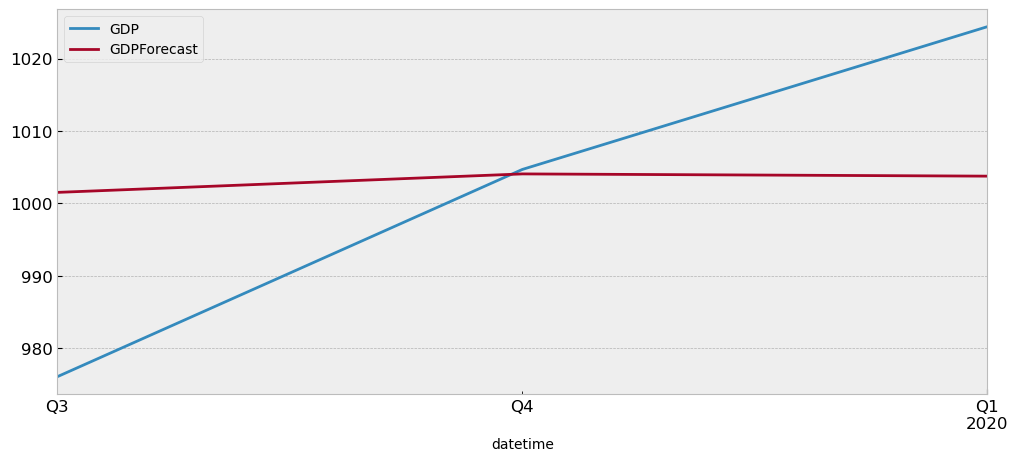

In [59]:
df['GDP'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=False)
df_forecast['GDPForecast'].plot(legend=True);

In [57]:
df_forecast.GDPForecast

2019-09-30    1001.532083
2019-12-31    1004.082474
2020-03-31    1003.774355
Freq: Q-DEC, Name: GDPForecast, dtype: float64

In [58]:
df['GDP'][-nobs:]

datetime
2019-07-01     976.1
2019-10-01    1004.7
2020-01-01    1024.4
Name: GDP, dtype: float64